#  Import Libraries 

In [1]:
# Libraries for data manipulation and analysis
# --------------------------------------------
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
# Visualization libraries
# -----------------------
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
# Machine Learning Models
# -----------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE

In [4]:
# Model Evaluation Metrics
# ------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, 
    ConfusionMatrixDisplay, RocCurveDisplay
)

In [5]:
# Random Seed
# -----------
SEED = 42


# Configure Pandas to display all rows and columns
# ------------------------------------------------
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# Suppress unnecessary warnings
# -----------------------------
import warnings
warnings.simplefilter("ignore")


# Import time module to measure detection time for each model
# ------------------------------------------------------------
import time

# Load and Preview Data

In [6]:
# Load the dataset into a Pandas DataFrame
# ----------------------------------------
smarthome_dataset = pd.read_csv('smarthome_data.csv')


# Display dataset summary
# -----------------------
smarthome_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712311 entries, 0 to 712310
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Header_Length    712311 non-null  float64
 1   Protocol Type    712311 non-null  int64  
 2   Time_To_Live     712311 non-null  float64
 3   Rate             712311 non-null  float64
 4   fin_flag_number  712311 non-null  float64
 5   syn_flag_number  712311 non-null  float64
 6   rst_flag_number  712311 non-null  float64
 7   psh_flag_number  712311 non-null  float64
 8   ack_flag_number  712311 non-null  float64
 9   ece_flag_number  712311 non-null  float64
 10  cwr_flag_number  712311 non-null  float64
 11  ack_count        712311 non-null  int64  
 12  syn_count        712311 non-null  int64  
 13  fin_count        712311 non-null  int64  
 14  rst_count        712311 non-null  int64  
 15  HTTP             712311 non-null  float64
 16  HTTPS            712311 non-null  floa

In [7]:
# Display the first five rows of the dataset
# ------------------------------------------
smarthome_dataset.head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IGMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,0.0,99,0,0,0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.99,0.00,0.0,0.01,0.00,0.0,0.99,0.99,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.01,0.0,1.00,1.00,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.99,0.0,0.00,0.01,0.0,1.00,1.00,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,0.0,4,0,1,3,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.70,0.20,0.0,0.10,0.00,0.0,0.90,0.90,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,0.0,1,0,0,0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.00,0.99,0.0,1.00,1.00,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD


# Clean Data

In [8]:
# Check for null values in the dataset
# ------------------------------------
if smarthome_dataset.isna().values.any():
    print("Dataset contains null values:")
    print(smarthome_dataset.isna().sum().loc[lambda x: x > 0])  # Display only columns with null values
else:
    print("Dataset does not contain null values.")

Dataset contains null values:
Std         11
Variance    11
dtype: int64


In [9]:
# Check for infinity values in numeric columns
# --------------------------------------------

# Extract only numeric columns
numeric_columns = smarthome_dataset.select_dtypes(include=np.number)

inf_counts = np.isinf(numeric_columns).sum()

if inf_counts.any():
    print("Dataset contains infinity values.")
    print(inf_counts[inf_counts > 0])  # Display only columns with infinity values
else:
    print("Dataset does not contain infinity values.")

Dataset contains infinity values.
Rate    14
dtype: int64


In [10]:
# Replace infinity values with NaN
# --------------------------------
smarthome_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
# Drop rows with any NaN values 
# -----------------------------
smarthome_dataset.dropna(inplace=True)

In [12]:
# Identify single-valued columns
# ------------------------------
single_valued_columns = [col for col in smarthome_dataset.columns if smarthome_dataset[col].nunique() == 1]

# Display the count and names of single-valued columns
print(f'There are {len(single_valued_columns)} single-valued columns:')
print(single_valued_columns)

There are 0 single-valued columns:
[]


In [13]:
# Convert flag number columns from float to integer
# -------------------------------------------------
flag_columns = [
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
    'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number'
]

smarthome_dataset[flag_columns] = smarthome_dataset[flag_columns].round().astype(int)

In [14]:
# Consolidate categories
# ----------------------

# Show categories
print("Number of Categories: ", smarthome_dataset['Label'].nunique())
print(smarthome_dataset['Label'].unique())

# Define a label mapping dictionary to categorize different attack types
label_mapping_dict = {
    'BENIGN': 'Benign',
    
    # Brute-force attacks
    'DICTIONARYBRUTEFORCE': 'BruteForce',
    
    # Distributed Denial-of-Service (DDoS) Attacks
    'DDOS-ACK_FRAGMENTATION': 'DDoS',
    'DDOS-HTTP_FLOOD': 'DDoS',
    'DDOS-ICMP_FLOOD': 'DDoS',
    'DDOS-ICMP_FRAGMENTATION': 'DDoS',
    'DDOS-PSHACK_FLOOD': 'DDoS',
    'DDOS-RSTFINFLOOD': 'DDoS',
    'DDOS-SYN_FLOOD': 'DDoS',
    'DDOS-SLOWLORIS': 'DDoS',
    'DDOS-SYNONYMOUSIP_FLOOD': 'DDoS',
    'DDOS-TCP_FLOOD': 'DDoS',
    'DDOS-UDP_FLOOD': 'DDoS',
    'DDOS-UDP_FRAGMENTATION': 'DDoS',
    
    # Denial-of-Service (DoS) Attacks
    'DOS-HTTP_FLOOD': 'DoS',
    'DOS-SYN_FLOOD': 'DoS',
    'DOS-TCP_FLOOD': 'DoS',
    'DOS-UDP_FLOOD': 'DoS',

    # Mirai Attacks
    'MIRAI-GREETH_FLOOD': 'Mirai',
    'MIRAI-GREIP_FLOOD': 'Mirai',
    'MIRAI-UDPPLAIN': 'Mirai',

    # Reconnaissance attacks
    'RECON-HOSTDISCOVERY': 'Recon',
    'RECON-OSSCAN': 'Recon',
    'RECON-PINGSWEEP': 'Recon',
    'RECON-PORTSCAN': 'Recon',
    'VULNERABILITYSCAN': 'Recon',
    
    # Spoofing attacks
    'DNS_SPOOFING': 'Spoofing',
    'MITM-ARPSPOOFING': 'Spoofing',

    # Web-based attacks
    'BACKDOOR_MALWARE': 'Web-Based',
    'BROWSERHIJACKING': 'Web-Based',
    'COMMANDINJECTION': 'Web-Based',
    'SQLINJECTION': 'Web-Based',
    'UPLOADING_ATTACK': 'Web-Based',
    'XSS': 'Web-Based'
}

# Map labels to categories
smarthome_dataset['Category'] = smarthome_dataset['Label'].replace(label_mapping_dict)

print("\nNumber of Categories after Mapping:", smarthome_dataset['Category'].nunique())
print(smarthome_dataset['Category'].unique())
print("\nCategory Distribution:\n", smarthome_dataset['Category'].value_counts())

Number of Categories:  34
['DDOS-PSHACK_FLOOD' 'MIRAI-GREIP_FLOOD' 'DOS-UDP_FLOOD' 'DNS_SPOOFING'
 'DDOS-ICMP_FLOOD' 'DDOS-TCP_FLOOD' 'DDOS-SYN_FLOOD' 'DDOS-UDP_FLOOD'
 'MITM-ARPSPOOFING' 'DDOS-SYNONYMOUSIP_FLOOD' 'DOS-TCP_FLOOD'
 'VULNERABILITYSCAN' 'DOS-SYN_FLOOD' 'DDOS-RSTFINFLOOD' 'BENIGN'
 'DDOS-SLOWLORIS' 'DDOS-ICMP_FRAGMENTATION' 'MIRAI-GREETH_FLOOD'
 'RECON-HOSTDISCOVERY' 'MIRAI-UDPPLAIN' 'RECON-PORTSCAN'
 'DDOS-ACK_FRAGMENTATION' 'DDOS-UDP_FRAGMENTATION' 'RECON-OSSCAN'
 'BACKDOOR_MALWARE' 'DOS-HTTP_FLOOD' 'XSS' 'DDOS-HTTP_FLOOD'
 'BROWSERHIJACKING' 'SQLINJECTION' 'DICTIONARYBRUTEFORCE'
 'COMMANDINJECTION' 'RECON-PINGSWEEP' 'UPLOADING_ATTACK']

Number of Categories after Mapping: 8
['DDoS' 'Mirai' 'DoS' 'Spoofing' 'Recon' 'Benign' 'Web-Based' 'BruteForce']

Category Distribution:
 Category
DDoS          515113
DoS           122494
Mirai          39661
Benign         16574
Recon          10562
Spoofing        7328
Web-Based        361
BruteForce       204
Name: count, dtype: int

In [15]:
# Identify duplicate rows
# -----------------------
duplicate_rows = smarthome_dataset[smarthome_dataset.duplicated()]
print(f"Number of duplicate rows (excluding first occurrences): {duplicate_rows.shape[0]}")

Number of duplicate rows (excluding first occurrences): 167370


In [16]:
# Remove duplicate rows while keeping the first occurrence
# --------------------------------------------------------
smarthome_dataset.drop_duplicates(inplace=True)

# Display the shape of the updated dataset
print(f"Dataset shape after removing duplicates: {smarthome_dataset.shape}\n")

# Count occurrences of each unique value in the category column
print(smarthome_dataset['Category'].value_counts())

Dataset shape after removing duplicates: (544927, 41)

Category
DDoS          367922
DoS           102641
Mirai          39567
Benign         16564
Recon          10552
Spoofing        7116
Web-Based        361
BruteForce       204
Name: count, dtype: int64


# Explore Data

In [17]:
# View first five rows of cleaned dataset
# ---------------------------------------
smarthome_dataset.head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IGMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label,Category
0,19.92,6,63.36,25893.962218,0,0,0,1,1,0,0,99,0,0,0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.99,0.00,0.0,0.01,0.00,0.0,0.99,0.99,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD,DDoS
1,0.00,47,64.00,3703.841331,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.01,0.0,1.00,1.00,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD,Mirai
2,7.92,17,65.91,19673.095685,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.99,0.0,0.00,0.01,0.0,1.00,1.00,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD,DoS
3,20.40,6,110.50,261.664826,0,0,0,0,0,0,0,4,0,1,3,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.70,0.20,0.0,0.10,0.00,0.0,0.90,0.90,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING,Spoofing
4,0.32,1,63.96,28944.199848,0,0,0,0,0,0,0,1,0,0,0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.00,0.99,0.0,1.00,1.00,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD,DDoS


In [18]:
# Show concise summary of dataset
# -------------------------------
smarthome_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544927 entries, 0 to 712309
Data columns (total 41 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Header_Length    544927 non-null  float64
 1   Protocol Type    544927 non-null  int64  
 2   Time_To_Live     544927 non-null  float64
 3   Rate             544927 non-null  float64
 4   fin_flag_number  544927 non-null  int32  
 5   syn_flag_number  544927 non-null  int32  
 6   rst_flag_number  544927 non-null  int32  
 7   psh_flag_number  544927 non-null  int32  
 8   ack_flag_number  544927 non-null  int32  
 9   ece_flag_number  544927 non-null  int32  
 10  cwr_flag_number  544927 non-null  int32  
 11  ack_count        544927 non-null  int64  
 12  syn_count        544927 non-null  int64  
 13  fin_count        544927 non-null  int64  
 14  rst_count        544927 non-null  int64  
 15  HTTP             544927 non-null  float64
 16  HTTPS            544927 non-null  float64
 

In [19]:
# Display the count of unique values for each column in the dataset  
# -----------------------------------------------------------------
for column in smarthome_dataset.columns:  
    print(column, smarthome_dataset[column].nunique())  

Header_Length 1230
Protocol Type 5
Time_To_Live 5691
Rate 109523
fin_flag_number 2
syn_flag_number 2
rst_flag_number 2
psh_flag_number 2
ack_flag_number 2
ece_flag_number 2
cwr_flag_number 2
ack_count 101
syn_count 101
fin_count 95
rst_count 101
HTTP 123
HTTPS 160
DNS 110
Telnet 5
SMTP 7
SSH 18
IRC 5
TCP 203
UDP 203
DHCP 25
ARP 122
ICMP 159
IGMP 7
IPv 122
LLC 122
Tot sum 26065
Min 443
Max 2366
AVG 26684
Std 74692
Tot size 26684
IAT 110249
Number 99
Variance 79359
Label 34
Category 8


## Visualize Data

In [20]:
# Get a sorted list of unique categories
# --------------------------------------
categories = sorted(list(smarthome_dataset['Category'].unique()))
print(categories)

['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web-Based']


Category    Protocol Type
Benign      0                    28
            1                     3
            6                 15186
            17                 1347
BruteForce  0                     2
            1                     1
            6                   155
            17                   46
DDoS        0                    14
            1                 73225
            6                232294
            17                62389
DoS         0                     1
            1                   154
            6                 59706
            17                42780
Mirai       0                     9
            1                     8
            6                   190
            17                13307
            47                26053
Recon       0                    93
            1                     4
            6                  8859
            17                 1596
Spoofing    0                    59
            1                     6
  

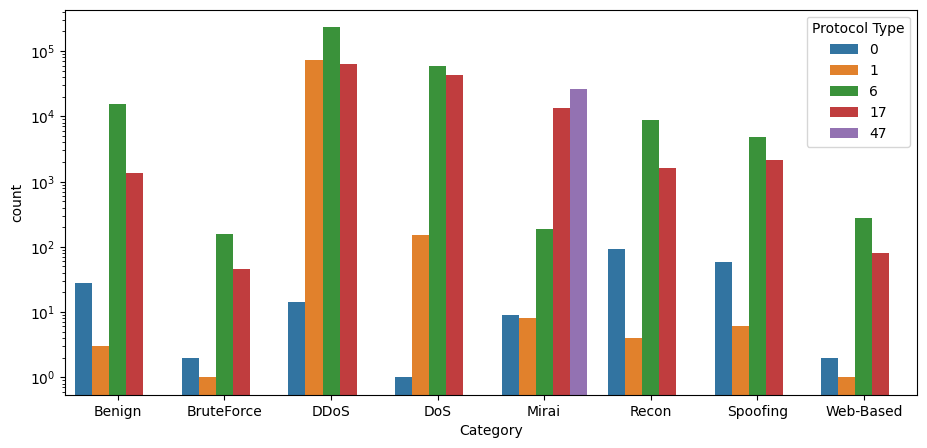

In [21]:
# Count and display the number of unique protocol types across categories
# -----------------------------------------------------------------------
print(smarthome_dataset.groupby(['Category', 'Protocol Type']).size())

plt.figure(figsize=(11,5))
sns.countplot(
    data=smarthome_dataset, 
    x='Category', 
    order=categories, 
    hue='Protocol Type'
)
plt.yscale('log')
plt.show()

Category
Benign        27.291034
BruteForce    23.490196
DDoS          13.898072
DoS           15.162522
Mirai          2.984530
Recon         23.052824
Spoofing      23.742116
Web-Based     22.469806
Name: Header_Length, dtype: float64


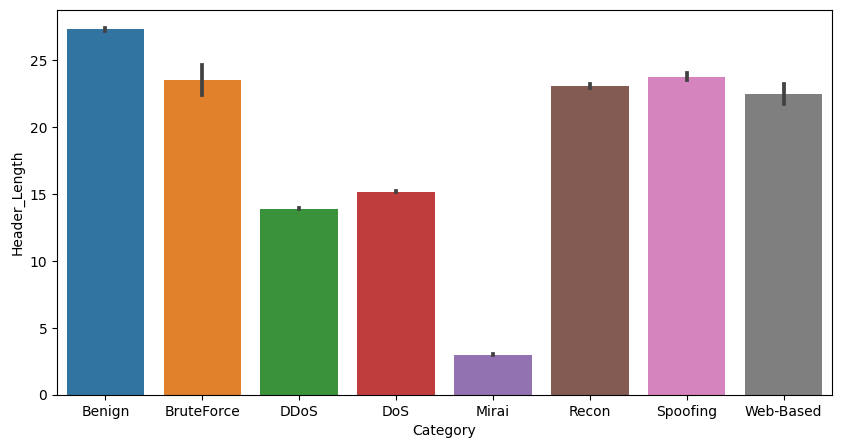

In [22]:
# Display the average header length for each category
# ---------------------------------------------------
print(smarthome_dataset.groupby('Category')['Header_Length'].mean())

plt.figure(figsize=(10,5))
sns.barplot(
    data=smarthome_dataset, 
    x='Category', 
    y='Header_Length', 
    order=categories
)
plt.show()

Category
DDoS          29440.720724
Spoofing      22096.316694
DoS           21097.697202
Recon         11048.939640
Mirai          5705.457794
Web-Based      4599.693775
Benign         2724.282163
BruteForce     1741.231457
Name: Rate, dtype: float64


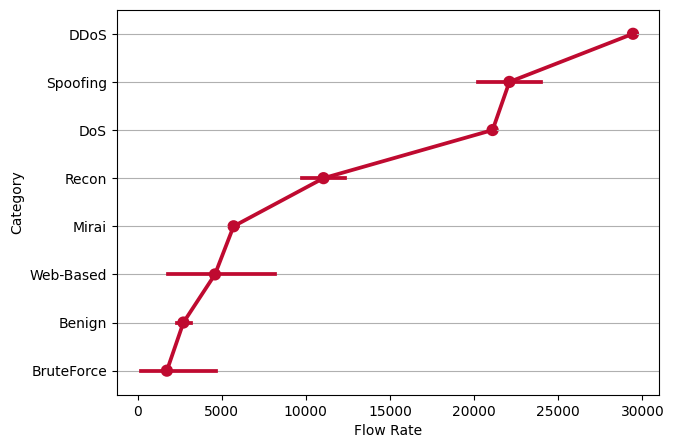

In [23]:
# Show the average flow rate for each category
# --------------------------------------------
mean_flow_rate_per_category = smarthome_dataset.groupby('Category')['Rate'].mean().sort_values(ascending=False)
print(mean_flow_rate_per_category)

plt.figure(figsize=(7,5))
sns.pointplot(
    data=smarthome_dataset, 
    x='Rate', 
    y='Category', 
    order=mean_flow_rate_per_category.index, 
    color='#BF0A30'
)
plt.grid(axis='y')
plt.xlabel('Flow Rate')
plt.show()

Category
Benign        616.211557
BruteForce    281.101471
DDoS           96.501779
DoS            78.935941
Mirai         566.464422
Recon         240.904232
Spoofing      579.740249
Web-Based     339.597784
Name: Tot size, dtype: float64


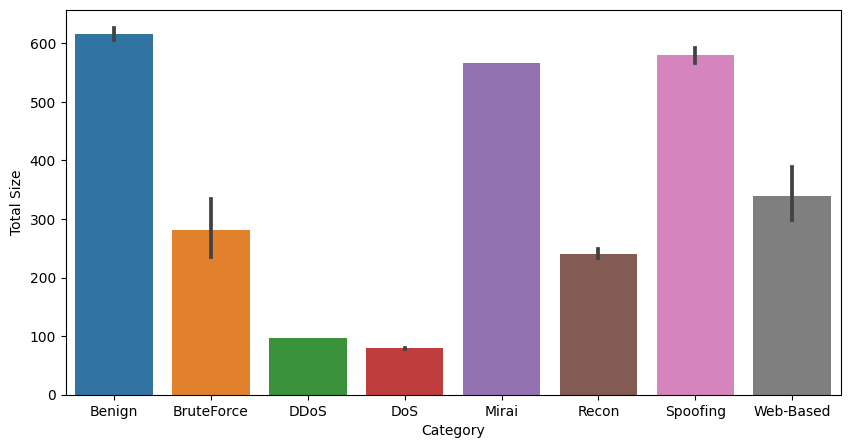

In [24]:
# Display the average packet size of each category
# --------------------------------------
print(smarthome_dataset.groupby('Category')['Tot size'].mean())

plt.figure(figsize=(10,5))
sns.barplot(
    data=smarthome_dataset,
    x='Category',
    y='Tot size',
    order=categories
)
plt.ylabel('Total Size')
plt.show()

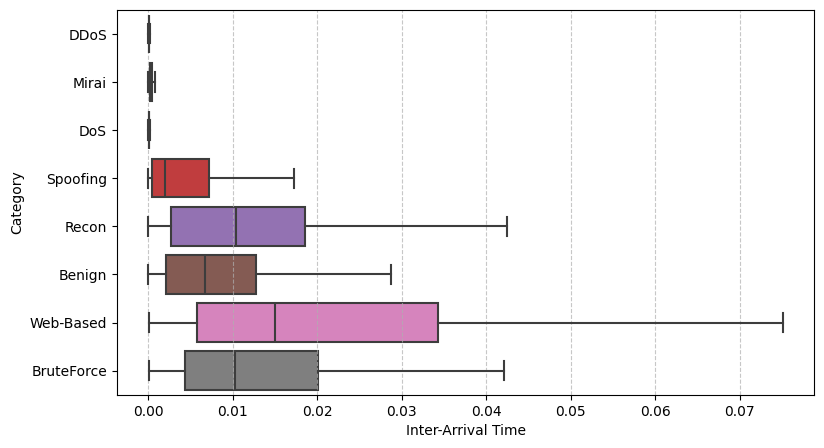

In [25]:
# Show the distribution of Inter-Arrival Time for each category
# -------------------------------------------------------------
plt.figure(figsize=(9,5))
sns.boxplot(
    data=smarthome_dataset, 
    x='IAT', 
    y='Category', 
    showfliers=False  # Hide outliers for a cleaner plot
)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Inter-Arrival Time')
plt.show()

ack_flag_number      1       0
Category                      
Benign           14092    2472
BruteForce         135      69
DDoS             48881  319041
DoS               1913  100728
Mirai              139   39428
Recon             5912    4640
Spoofing          4501    2615
Web-Based          227     134 

                  Set    Not Set
Category                        
Benign      85.076069  14.923931
BruteForce  66.176471  33.823529
DDoS        13.285696  86.714304
DoS          1.863778  98.136222
Mirai        0.351303  99.648697
Recon       56.027293  43.972707
Spoofing    63.251827  36.748173
Web-Based   62.880886  37.119114 



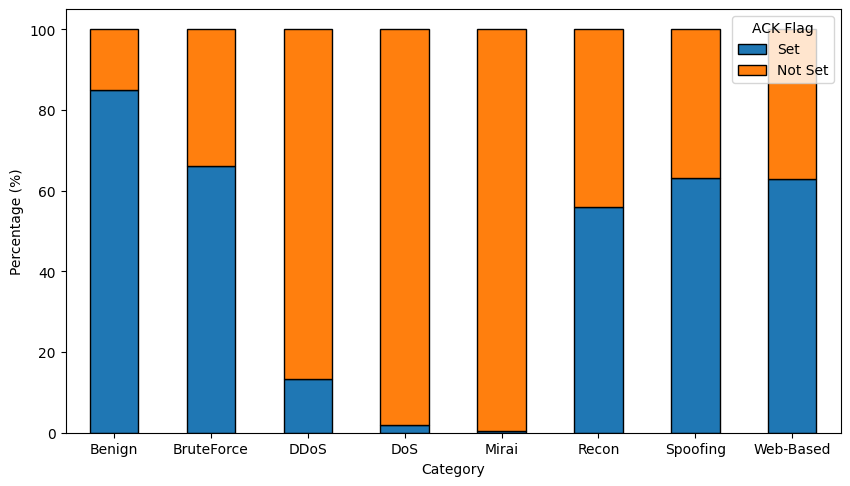

In [26]:
# Show the distribution of 'ack_flag_number' within each category
# ---------------------------------------------------------------
ack_flag_count = smarthome_dataset.groupby('Category')['ack_flag_number'].value_counts().unstack()
ack_flag_count = ack_flag_count[ack_flag_count.columns[::-1]]  # Reverse Columns Order
print(ack_flag_count, '\n')

# Calculate the percentage of each unique 'ack_flag_number' per category
ack_flag = smarthome_dataset.groupby('Category')['ack_flag_number'].value_counts(normalize=True).unstack() * 100
ack_flag.columns = ['Not Set', 'Set']
ack_flag = ack_flag[ack_flag.columns[::-1]]

print(ack_flag, '\n')

# Plot the stacked bar chart
ack_flag.plot(
    kind='bar', 
    stacked=True, 
    edgecolor='black', 
    figsize=(10, 5.5)
)
plt.xticks(rotation=0)
plt.legend(title="ACK Flag", loc="upper right")  # Ensure the legend appears with a title
plt.ylabel('Percentage (%)')
plt.show()

# Transform Labels

## For Binary Classification

In [27]:
# Map 'Benign' to 0 and all other categories to 1
# -----------------------------------------------
smarthome_dataset['Binary Category Code'] = smarthome_dataset['Category'].apply(lambda x: 0 if x == 'Benign' else 1)

# Display the count of the two classes
print(smarthome_dataset['Binary Category Code'].value_counts(ascending=True))

Binary Category Code
0     16564
1    528363
Name: count, dtype: int64


Benign      16564
Anomaly    528363
Name: count, dtype: int64


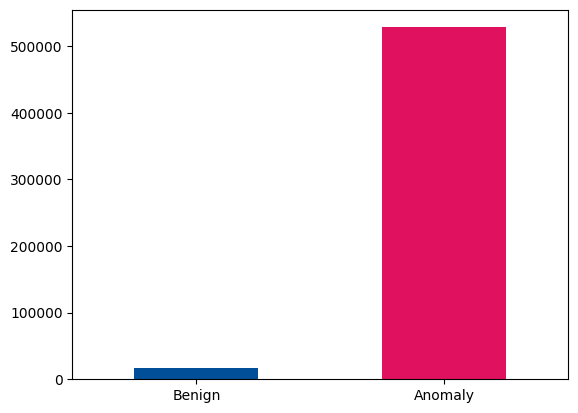

In [28]:
# Show binary classification categories
# -------------------------------------
binary_code_count = smarthome_dataset['Binary Category Code'].value_counts(ascending=True)
binary_code_count.index = ['Benign', 'Anomaly']
print(binary_code_count)

binary_code_count.plot(
    kind='bar', 
    color=['#004F98', '#E0115F']
)
plt.xticks(rotation=0)
plt.show()

 ## For Multi-class Classification

In [29]:
# Assign number to each category
# ------------------------------
category_to_index_mapping = {category: index for index, category in enumerate(categories)}

category_to_index_mapping

{'Benign': 0,
 'BruteForce': 1,
 'DDoS': 2,
 'DoS': 3,
 'Mirai': 4,
 'Recon': 5,
 'Spoofing': 6,
 'Web-Based': 7}

In [30]:
# Map categories to unique numbers
# --------------------------------
smarthome_dataset['MultiClass Category Code'] = smarthome_dataset['Category'].map(category_to_index_mapping)

# Display the count of each unique numerical label in the dataset
print(smarthome_dataset['MultiClass Category Code'].value_counts())

MultiClass Category Code
2    367922
3    102641
4     39567
0     16564
5     10552
6      7116
7       361
1       204
Name: count, dtype: int64


Category
DDoS          367922
DoS           102641
Mirai          39567
Benign         16564
Recon          10552
Spoofing        7116
Web-Based        361
BruteForce       204
Name: count, dtype: int64


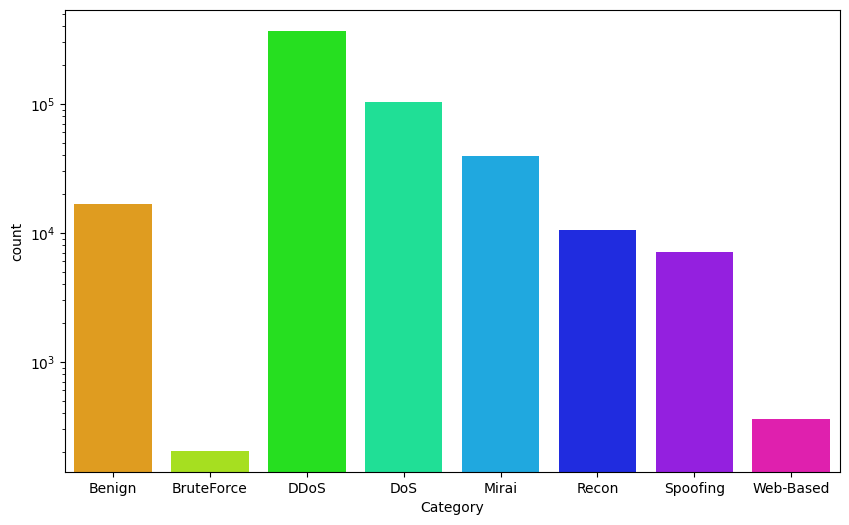

In [31]:
# Show Categories
# ---------------
print(smarthome_dataset['Category'].value_counts())

plt.figure(figsize=(10,6))
sns.countplot(
    data=smarthome_dataset, 
    x='Category', 
    order=categories, 
    palette='hsv'
)
plt.yscale('log')
plt.show()

### Separation of Features and Labels

In [32]:
# Show column information
# -----------------------
smarthome_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544927 entries, 0 to 712309
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Header_Length             544927 non-null  float64
 1   Protocol Type             544927 non-null  int64  
 2   Time_To_Live              544927 non-null  float64
 3   Rate                      544927 non-null  float64
 4   fin_flag_number           544927 non-null  int32  
 5   syn_flag_number           544927 non-null  int32  
 6   rst_flag_number           544927 non-null  int32  
 7   psh_flag_number           544927 non-null  int32  
 8   ack_flag_number           544927 non-null  int32  
 9   ece_flag_number           544927 non-null  int32  
 10  cwr_flag_number           544927 non-null  int32  
 11  ack_count                 544927 non-null  int64  
 12  syn_count                 544927 non-null  int64  
 13  fin_count                 544927 non-null  int64 

In [33]:
# Drop target columns to get only features
# ----------------------------------------
numeric_features = list(smarthome_dataset.columns.drop(['Label', 'Category',
                                                        'Binary Category Code',
                                                        'MultiClass Category Code']))

# Features
X = smarthome_dataset[numeric_features].values

# Target variable for binary classification
binary_y = smarthome_dataset['Binary Category Code'].values

# Target variable for multi-class classification
multiclass_y = smarthome_dataset['MultiClass Category Code'].values

# Train and Evaluate Model

In [34]:
# Instantiate models
# ------------------
models = [
    RandomForestClassifier(random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    KNeighborsClassifier(),
    LogisticRegression(random_state=SEED),
    LinearSVC(random_state=SEED)
]

## Binary Classification

In [35]:
# Split data into 70% training set and 30% test set
# -------------------------------------------------
binary_X_train, binary_X_test, binary_y_train, binary_y_test = train_test_split(X, binary_y,
                                                                                test_size=0.3,
                                                                                stratify=binary_y,
                                                                                random_state=SEED)

Before SMOTE: Counter({1: 369853, 0: 11595})
After SMOTE: Counter({1: 369853, 0: 369853})


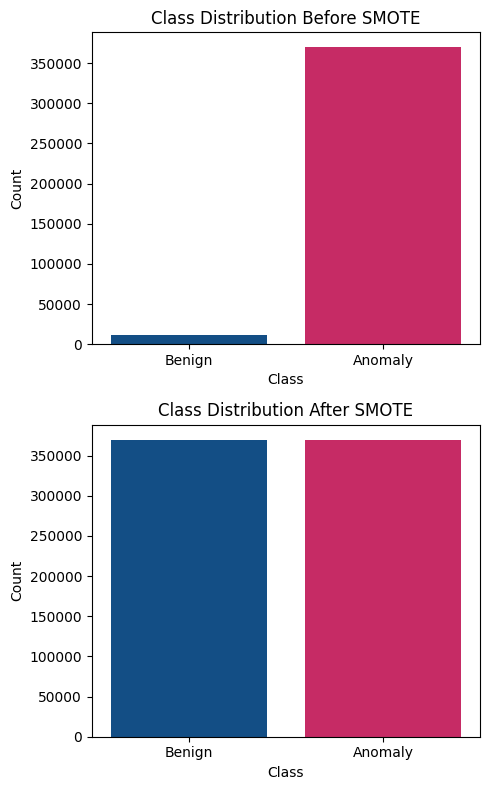

In [36]:
# Apply SMOTE to balance the classes in the training set
# ------------------------------------------------------

# Check class distribution before SMOTE
print("Before SMOTE:", Counter(binary_y_train))

# Generate synthetic samples for the minority class
smote = SMOTE(random_state=SEED)
binary_X_train_resampled, binary_y_train_resampled = smote.fit_resample(binary_X_train, binary_y_train)

# Check class distribution after SMOTE
print("After SMOTE:", Counter(binary_y_train_resampled))

# View binary class distribution in the training set before and after SMOTE
# Create DataFrames for before and after SMOTE
before_df_binary = pd.DataFrame({'Class': binary_y_train})
after_df_binary = pd.DataFrame({'Class': binary_y_train_resampled})

# Plot vertically stacked countplots
plt.figure(figsize=(5, 8))

# Before SMOTE
plt.subplot(2, 1, 1)
sns.countplot(
    data=before_df_binary,
    x='Class', 
    palette=['#004F98', '#E0115F']
)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], 
           labels=['Benign', 'Anomaly'])

# After SMOTE
plt.subplot(2, 1, 2)
sns.countplot(
    data=after_df_binary,
    x='Class',
    palette=['#004F98', '#E0115F']
)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1],
           labels=['Benign', 'Anomaly'])

plt.tight_layout()
plt.show()


Binary Classification Evaluation Results for RandomForestClassifier: 
----------------------------------------------------------------------
Accuracy: 0.989
Precision: 0.996
True Positive Rate: 0.992
True Negative Rate: 0.879
F1 Score: 0.994
ROC AUC Score: 0.936
Detection Time (s): 1.506

Confusion Matrix:
[[  4367    602]
 [  1224 157286]]


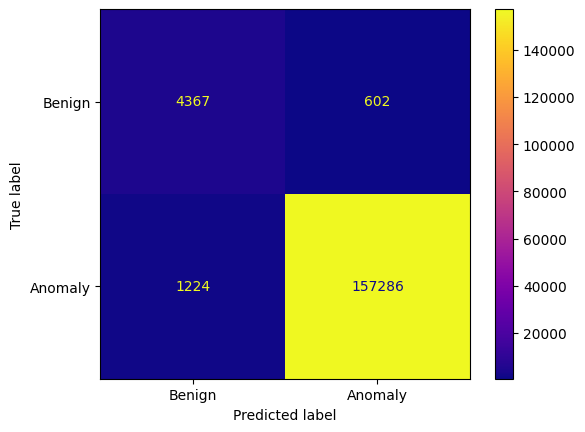


Classification Report:
              precision    recall  f1-score   support

      Benign       0.78      0.88      0.83      4969
     Anomaly       1.00      0.99      0.99    158510

    accuracy                           0.99    163479
   macro avg       0.89      0.94      0.91    163479
weighted avg       0.99      0.99      0.99    163479



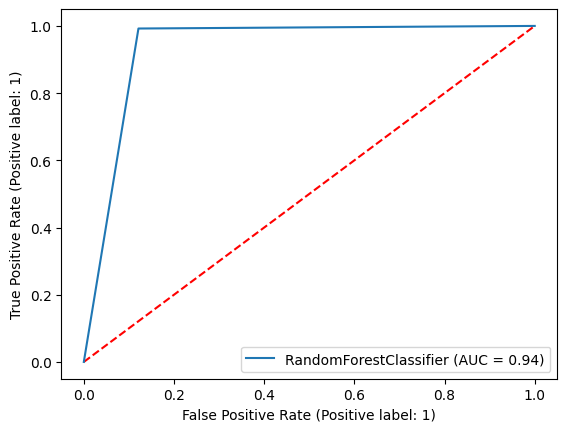


Binary Classification Evaluation Results for DecisionTreeClassifier: 
----------------------------------------------------------------------
Accuracy: 0.986
Precision: 0.993
True Positive Rate: 0.992
True Negative Rate: 0.791
F1 Score: 0.993
ROC AUC Score: 0.892
Detection Time (s): 0.016

Confusion Matrix:
[[  3932   1037]
 [  1292 157218]]


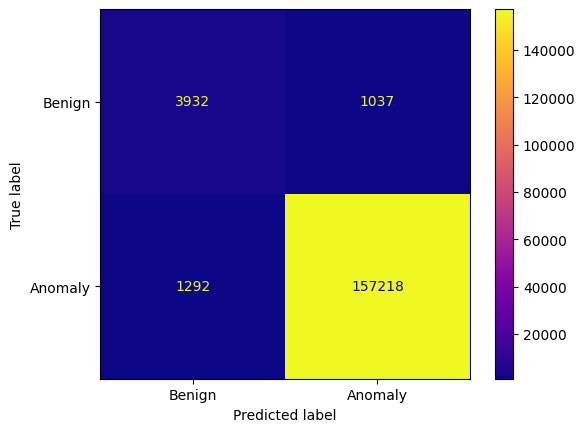


Classification Report:
              precision    recall  f1-score   support

      Benign       0.75      0.79      0.77      4969
     Anomaly       0.99      0.99      0.99    158510

    accuracy                           0.99    163479
   macro avg       0.87      0.89      0.88    163479
weighted avg       0.99      0.99      0.99    163479



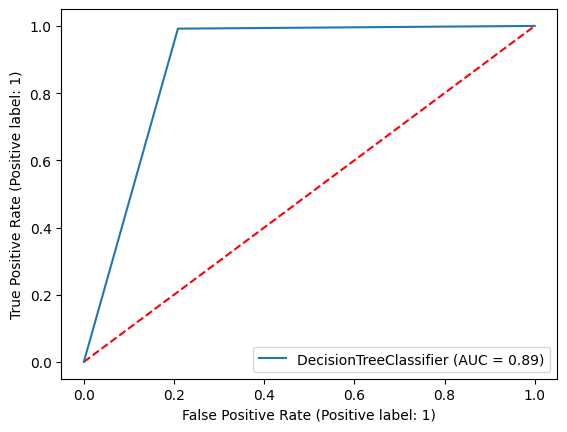


Binary Classification Evaluation Results for KNeighborsClassifier: 
----------------------------------------------------------------------
Accuracy: 0.976
Precision: 0.998
True Positive Rate: 0.977
True Negative Rate: 0.935
F1 Score: 0.987
ROC AUC Score: 0.956
Detection Time (s): 347.76

Confusion Matrix:
[[  4644    325]
 [  3636 154874]]


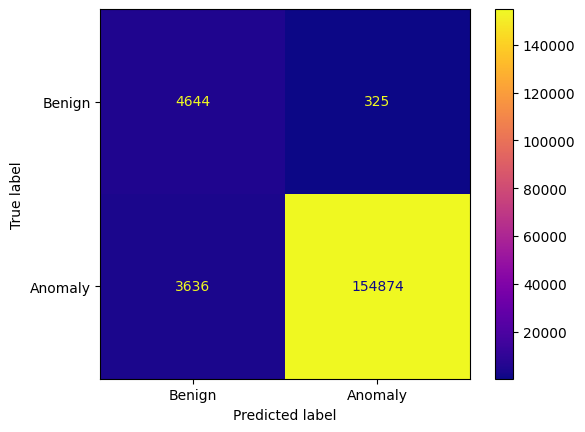


Classification Report:
              precision    recall  f1-score   support

      Benign       0.56      0.93      0.70      4969
     Anomaly       1.00      0.98      0.99    158510

    accuracy                           0.98    163479
   macro avg       0.78      0.96      0.84    163479
weighted avg       0.98      0.98      0.98    163479



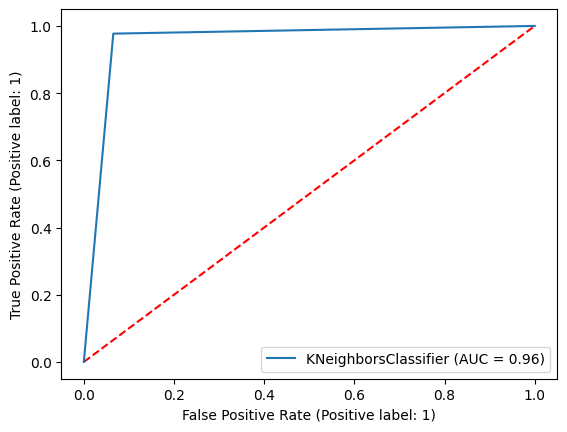


Binary Classification Evaluation Results for LogisticRegression: 
----------------------------------------------------------------------
Accuracy: 0.966
Precision: 1.0
True Positive Rate: 0.965
True Negative Rate: 1.0
F1 Score: 0.982
ROC AUC Score: 0.983
Detection Time (s): 0.009

Confusion Matrix:
[[  4969      0]
 [  5517 152993]]


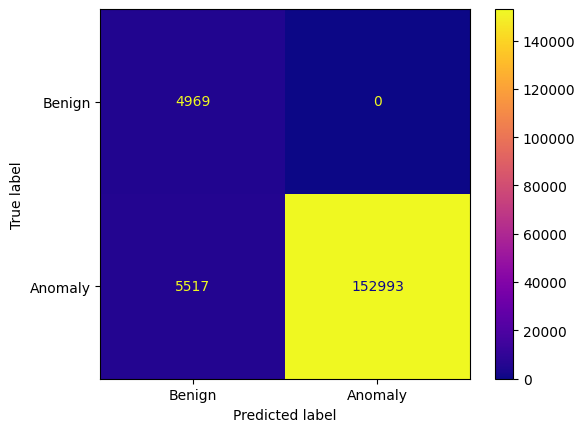


Classification Report:
              precision    recall  f1-score   support

      Benign       0.47      1.00      0.64      4969
     Anomaly       1.00      0.97      0.98    158510

    accuracy                           0.97    163479
   macro avg       0.74      0.98      0.81    163479
weighted avg       0.98      0.97      0.97    163479



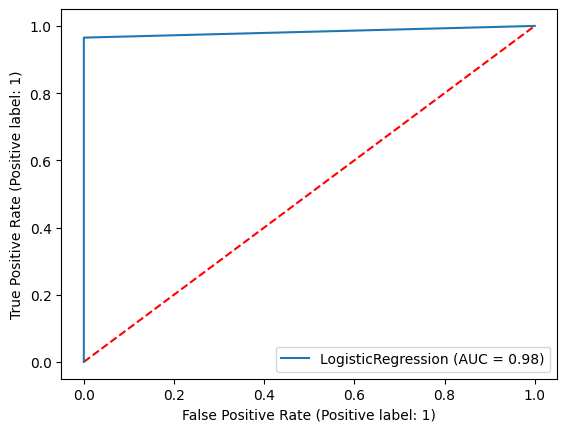


Binary Classification Evaluation Results for LinearSVC: 
----------------------------------------------------------------------
Accuracy: 0.971
Precision: 1.0
True Positive Rate: 0.97
True Negative Rate: 0.995
F1 Score: 0.985
ROC AUC Score: 0.983
Detection Time (s): 0.016

Confusion Matrix:
[[  4945     24]
 [  4738 153772]]


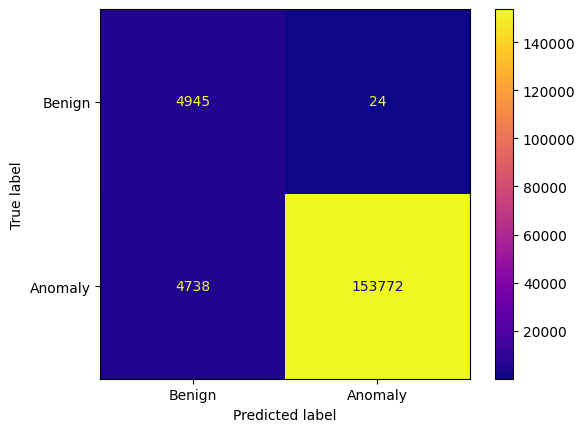


Classification Report:
              precision    recall  f1-score   support

      Benign       0.51      1.00      0.67      4969
     Anomaly       1.00      0.97      0.98    158510

    accuracy                           0.97    163479
   macro avg       0.76      0.98      0.83    163479
weighted avg       0.98      0.97      0.98    163479



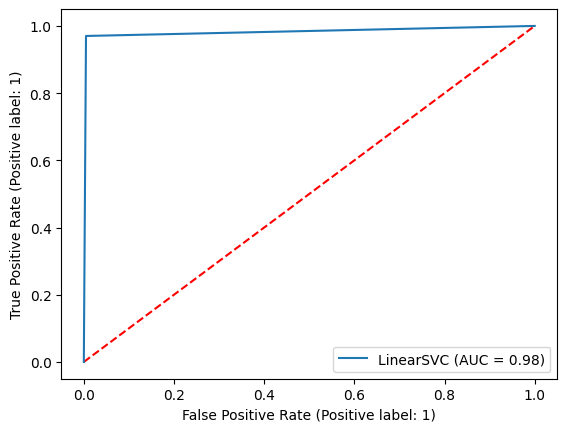

In [37]:
# Dictionary to store evaluation results
# --------------------------------------
binary_results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "True Positive Rate": [],
    "True Negative Rate": [],
    "F1 Score": [],
    "ROC AUC Score": [],
    "Detection Time (s)": []
}


for model in models:
    model_name = model.__class__.__name__
    
    # Train the model
    model.fit(binary_X_train_resampled, binary_y_train_resampled) 
    
    # Measure detection time
    start_time = time.time()
    model_pred = model.predict(binary_X_test)               
    end_time = time.time()
    
    detection_time = round(end_time - start_time, 3)  # Time in seconds, rounded to 3 decimal places             
    
    # Compute confusion matrix
    cm = confusion_matrix(binary_y_test, model_pred)

    # Compute metrics (rounded to 3 decimal places)
    accuracy = round(accuracy_score(binary_y_test, model_pred), 3)
    precision = round(precision_score(binary_y_test, model_pred), 3)
    tpr = round(recall_score(binary_y_test, model_pred), 3)
    tnr = round(cm[0, 0] / cm[0].sum(), 3)
    f1score = round(f1_score(binary_y_test, model_pred), 3)
    roc_auc = round(roc_auc_score(binary_y_test, model_pred), 3)
    
    # Store results in the dictionary
    binary_results["Model"].append(model_name)
    binary_results["Accuracy"].append(accuracy)
    binary_results["Precision"].append(precision)
    binary_results["True Positive Rate"].append(tpr)
    binary_results["True Negative Rate"].append(tnr)
    binary_results["F1 Score"].append(f1score)
    binary_results["ROC AUC Score"].append(roc_auc)
    binary_results["Detection Time (s)"].append(detection_time)

    # Print results
    print(f"\nBinary Classification Evaluation Results for {model_name}: ")
    print("----------------------------------------------------------------------")
        
    metrics = ["Accuracy", "Precision", "True Positive Rate", "True Negative Rate", 
               "F1 Score", "ROC AUC Score", "Detection Time (s)"]
    values = [accuracy, precision, tpr, tnr, f1score, roc_auc, detection_time]
    for metric, value in zip(metrics, values):
        print(f"{metric}: {value}")

    # Print Confusion Matrix
    print("\nConfusion Matrix:")
    print(cm)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_code_count.index)
    cm_display.plot(cmap='plasma')
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(binary_y_test, model_pred, target_names=binary_code_count.index))

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'r--')  # Diagonal reference line
    RocCurveDisplay.from_predictions(binary_y_test, model_pred, name=model_name, ax=ax)
    plt.show()

    print("=====================================================================================")

In [38]:
# Convert results dictionary to a DataFrame
# -----------------------------------------
binary_results_df = pd.DataFrame(binary_results)
print("\nFinal Summary of Model Performance:")
print(binary_results_df)


Final Summary of Model Performance:
                    Model  Accuracy  Precision  True Positive Rate  \
0  RandomForestClassifier     0.989      0.996               0.992   
1  DecisionTreeClassifier     0.986      0.993               0.992   
2    KNeighborsClassifier     0.976      0.998               0.977   
3      LogisticRegression     0.966      1.000               0.965   
4               LinearSVC     0.971      1.000               0.970   

   True Negative Rate  F1 Score  ROC AUC Score  Detection Time (s)  
0               0.879     0.994          0.936               1.506  
1               0.791     0.993          0.892               0.016  
2               0.935     0.987          0.956             347.760  
3               1.000     0.982          0.983               0.009  
4               0.995     0.985          0.983               0.016  


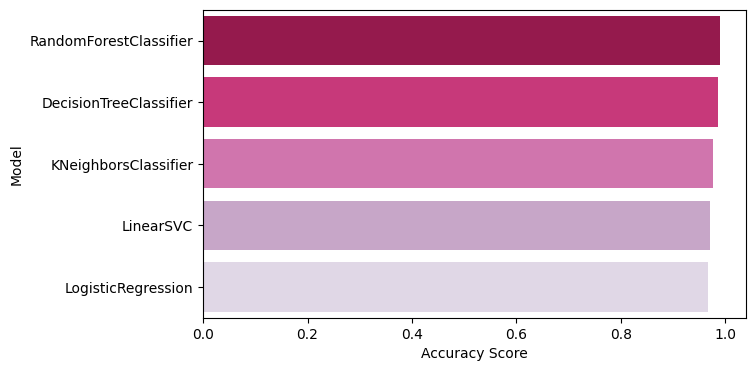

In [39]:
# Show accuracy scores
# --------------------
plt.figure(figsize=(7,4))
sns.barplot(
    data=binary_results_df.sort_values(by='Accuracy', ascending=False),
    x='Accuracy', 
    y='Model', 
    palette='PuRd_r'
)
plt.xlabel("Accuracy Score")
plt.show()

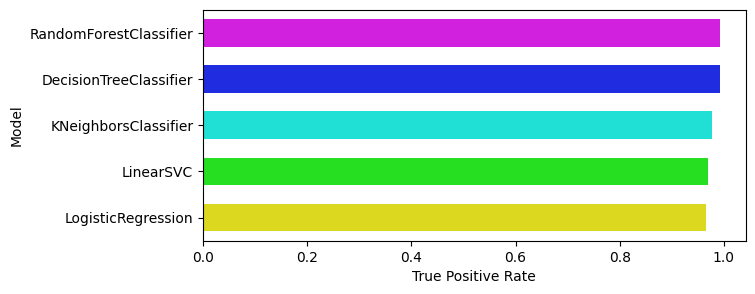

In [40]:
# Show True Positive Rates
# ------------------------
plt.figure(figsize=(7,3))
sns.barplot(
    data=binary_results_df.sort_values(by='True Positive Rate', ascending=False),
    x='True Positive Rate', 
    y='Model', 
    width=0.6, 
    palette='hsv_r'
)

plt.show()

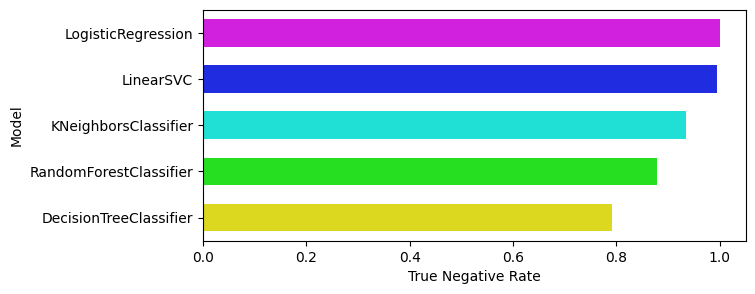

In [41]:
# Show True Negative Rates
# ------------------------
plt.figure(figsize=(7,3))
sns.barplot(
    data=binary_results_df.sort_values(by='True Negative Rate', ascending=False),
    x='True Negative Rate', 
    y='Model', 
    width=0.6, 
    palette='hsv_r'
)
plt.show()

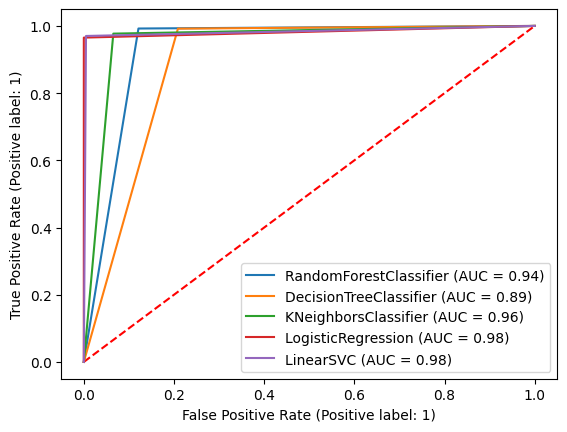

In [42]:
# Show all ROC_AUC curves in one chart
# ------------------------------------
ax = plt.gca()
ax.plot([0, 1], [0, 1], 'r--')

for model in models:
    model_name = model.__class__.__name__

    model.fit(binary_X_train_resampled, binary_y_train_resampled) 
    model_pred = model.predict(binary_X_test)  

    RocCurveDisplay.from_predictions(binary_y_test, model_pred, name=model_name, ax=ax)

plt.show()

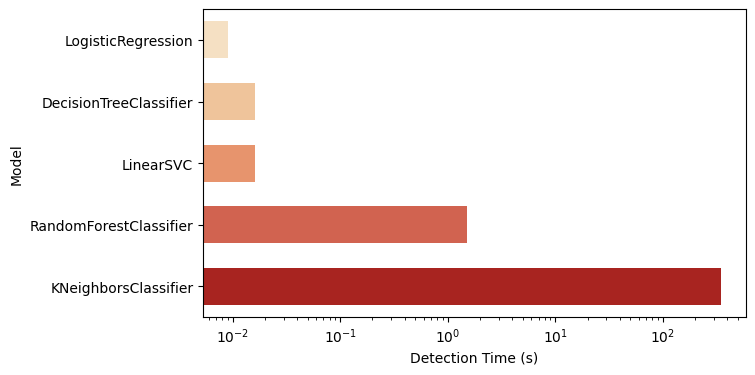

In [43]:
# Show Detection Times
# ---------------------
plt.figure(figsize=(7,4))
sns.barplot(
    data=binary_results_df.sort_values(by='Detection Time (s)'),
    x='Detection Time (s)', 
    y='Model', 
    width=0.6, 
    palette='OrRd'
)
plt.xscale('log')
plt.show()

## Multi-class Classification

In [44]:
# Split data into 70% training set and 30% test set
# -------------------------------------------------
multiclass_X_train, multiclass_X_test, multiclass_y_train, multiclass_y_test = train_test_split(X, multiclass_y,
                                                                                                test_size=0.3,
                                                                                                stratify=multiclass_y,
                                                                                                random_state=SEED)

Before SMOTE: Counter({2: 257545, 3: 71848, 4: 27697, 0: 11595, 5: 7386, 6: 4981, 7: 253, 1: 143})
After SMOTE: Counter({2: 257545, 0: 257545, 3: 257545, 4: 257545, 6: 257545, 5: 257545, 1: 257545, 7: 257545})


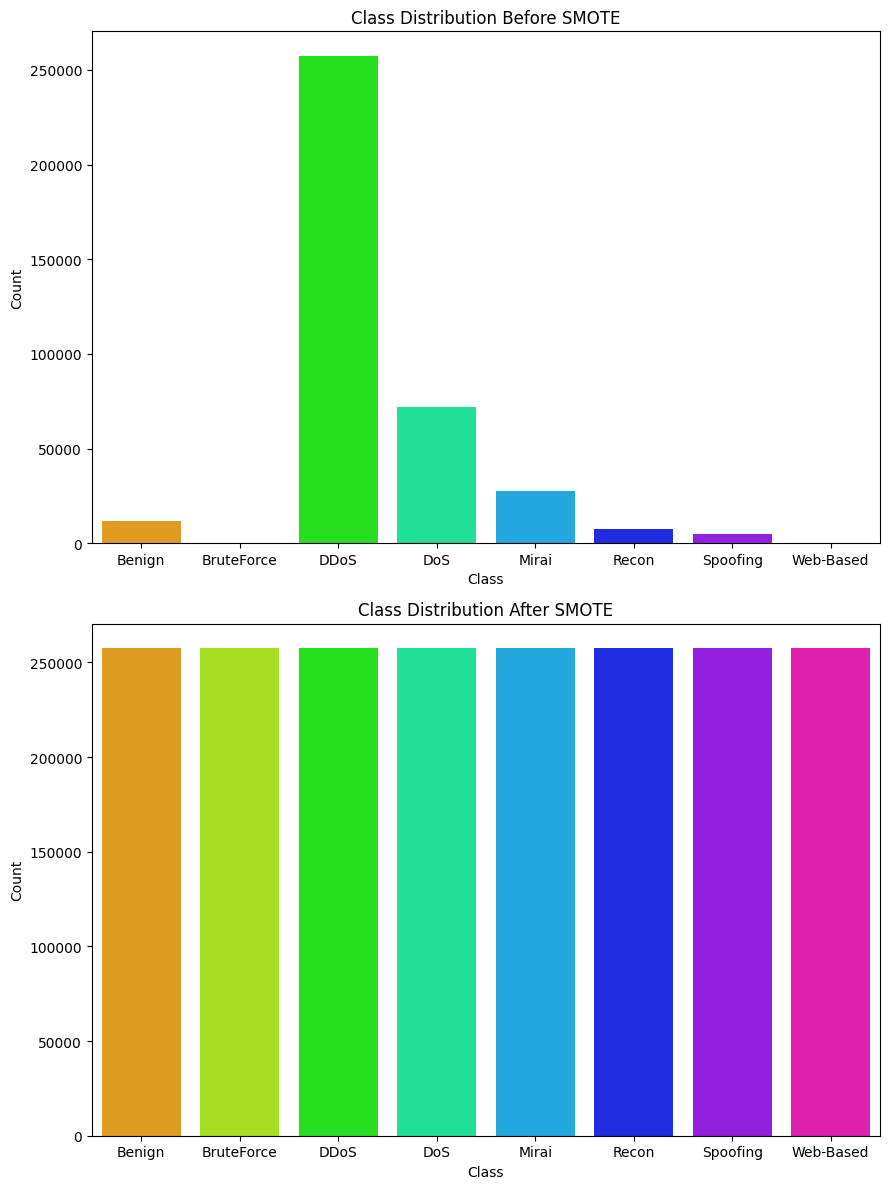

In [45]:
# Apply SMOTE to balance the classes in the training set
# ------------------------------------------------------

# Check class distribution before applying SMOTE
print("Before SMOTE:", Counter(multiclass_y_train))

# Initialize SMOTE for oversampling the minority classes
smote = SMOTE(random_state=SEED)
multiclass_X_train_resampled, multiclass_y_train_resampled = smote.fit_resample(multiclass_X_train, multiclass_y_train)

# Check class distribution after applying SMOTE
print("After SMOTE:", Counter(multiclass_y_train_resampled))

# View multiclass class distribution in the training set before and after SMOTE
# Create DataFrames for before and after SMOTE
before_df_multiclass = pd.DataFrame({'Class': multiclass_y_train})
after_df_multiclass = pd.DataFrame({'Class': multiclass_y_train_resampled})

# Plot vertically stacked countplots
plt.figure(figsize=(9, 12))

# Before SMOTE
plt.subplot(2, 1, 1)
sns.countplot(
    data=before_df_multiclass,
    x='Class',
    palette='hsv'
)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=list(category_to_index_mapping.values()),
           labels=list(category_to_index_mapping.keys()))

# After SMOTE
plt.subplot(2, 1, 2)
sns.countplot(
    data=after_df_multiclass,
    x='Class',
    palette='hsv'
)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=list(category_to_index_mapping.values()),
           labels=list(category_to_index_mapping.keys()))

plt.tight_layout()
plt.show()


Multi-class Classification Evaluation Results for RandomForestClassifier: 
---------------------------------------------------------------------------
Accuracy: 0.803
Detection Time (s): 5.614

Confusion Matrix:
[[ 4207     6     0     0     0   657    92     7]
 [   25    11     0     0     0    22     3     0]
 [    1     0 90669 19678    27     2     0     0]
 [    0     0 10448 20340     4     1     0     0]
 [    0     0    20     2 11847     0     1     0]
 [  706     2     0     0     0  2376    73     9]
 [  245     0     0     0     0   100  1784     6]
 [   31     0     0     0     0    60     3    14]]


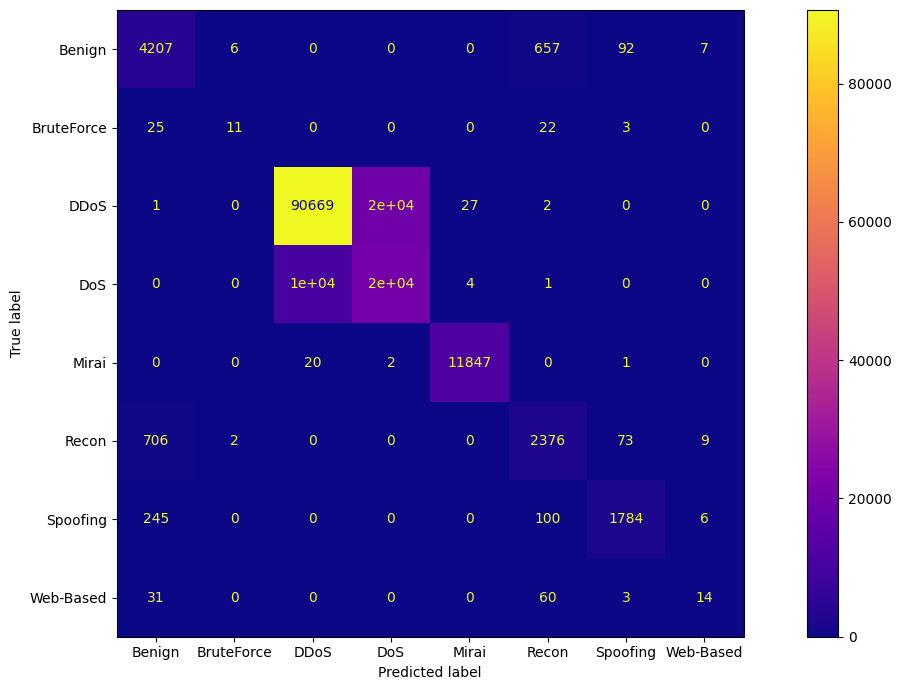


Classification Report:
              precision    recall  f1-score   support

      Benign       0.81      0.85      0.83      4969
  BruteForce       0.58      0.18      0.28        61
        DDoS       0.90      0.82      0.86    110377
         DoS       0.51      0.66      0.57     30793
       Mirai       1.00      1.00      1.00     11870
       Recon       0.74      0.75      0.74      3166
    Spoofing       0.91      0.84      0.87      2135
   Web-Based       0.39      0.13      0.19       108

    accuracy                           0.80    163479
   macro avg       0.73      0.65      0.67    163479
weighted avg       0.82      0.80      0.81    163479


Multi-class Classification Evaluation Results for DecisionTreeClassifier: 
---------------------------------------------------------------------------
Accuracy: 0.786
Detection Time (s): 0.094

Confusion Matrix:
[[ 3757    18     0     1     0   891   248    54]
 [   23    14     0     0     0    20     2     2]
 [    1   

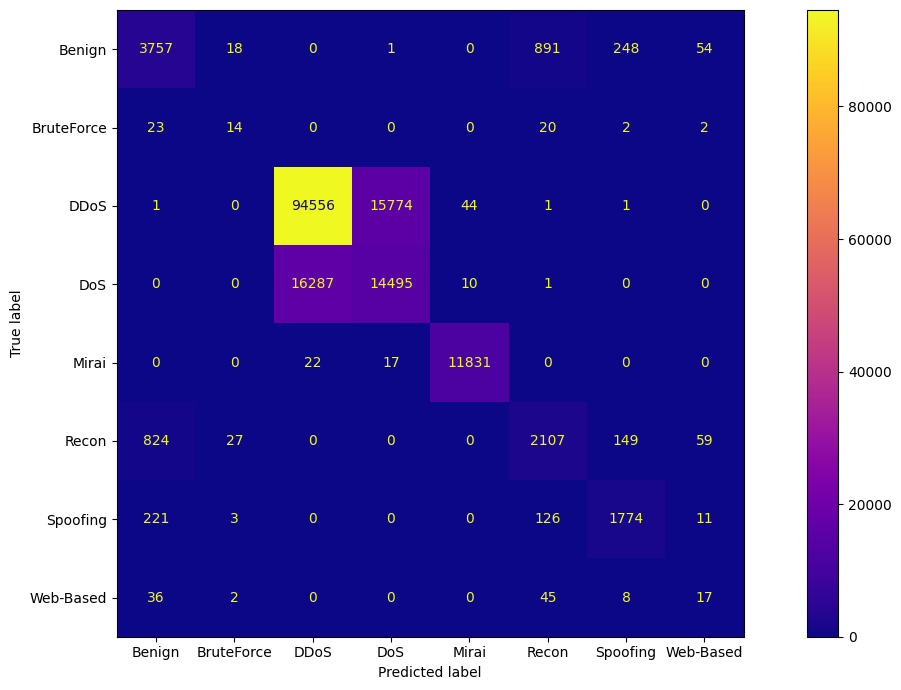


Classification Report:
              precision    recall  f1-score   support

      Benign       0.77      0.76      0.76      4969
  BruteForce       0.22      0.23      0.22        61
        DDoS       0.85      0.86      0.85    110377
         DoS       0.48      0.47      0.47     30793
       Mirai       1.00      1.00      1.00     11870
       Recon       0.66      0.67      0.66      3166
    Spoofing       0.81      0.83      0.82      2135
   Web-Based       0.12      0.16      0.14       108

    accuracy                           0.79    163479
   macro avg       0.61      0.62      0.62    163479
weighted avg       0.79      0.79      0.79    163479


Multi-class Classification Evaluation Results for KNeighborsClassifier: 
---------------------------------------------------------------------------
Accuracy: 0.733
Detection Time (s): 1045.453

Confusion Matrix:
[[ 2838   356     1     1     0   936   510   327]
 [   15    12     0     0     0    15    15     4]
 [   30  

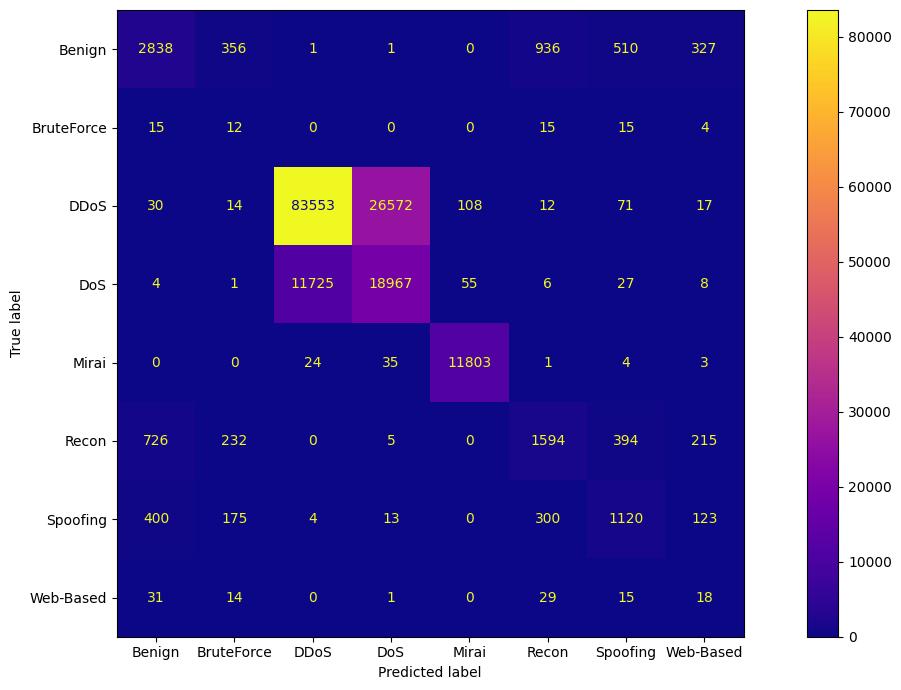


Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.57      0.63      4969
  BruteForce       0.01      0.20      0.03        61
        DDoS       0.88      0.76      0.81    110377
         DoS       0.42      0.62      0.50     30793
       Mirai       0.99      0.99      0.99     11870
       Recon       0.55      0.50      0.53      3166
    Spoofing       0.52      0.52      0.52      2135
   Web-Based       0.03      0.17      0.04       108

    accuracy                           0.73    163479
   macro avg       0.51      0.54      0.51    163479
weighted avg       0.78      0.73      0.75    163479


Multi-class Classification Evaluation Results for LogisticRegression: 
---------------------------------------------------------------------------
Accuracy: 0.749
Detection Time (s): 0.047

Confusion Matrix:
[[  2371      0   1037    106    853      0    531     71]
 [    21      0     14      3     17      0      5      1

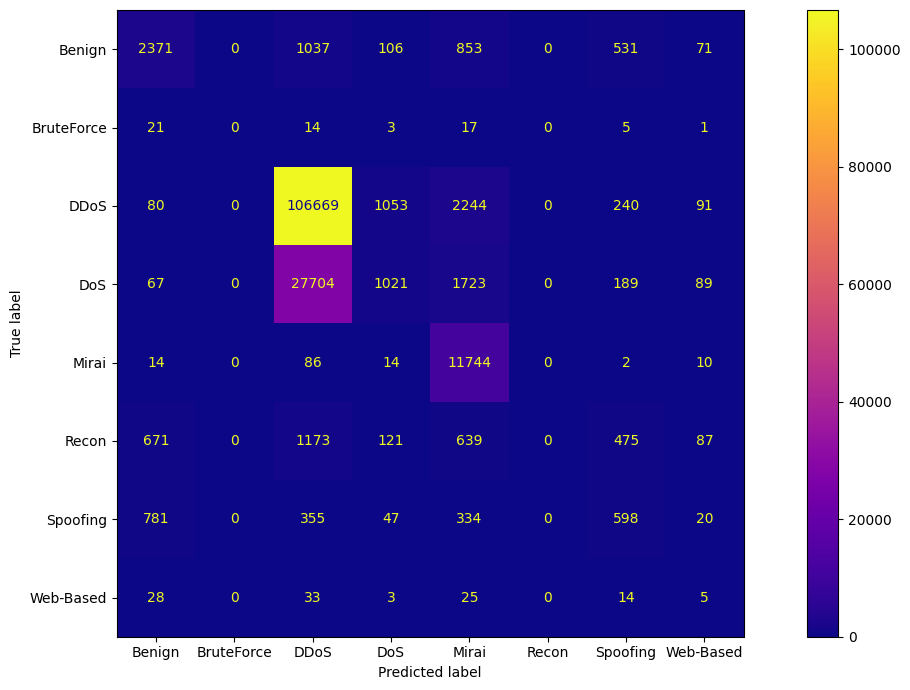


Classification Report:
              precision    recall  f1-score   support

      Benign       0.59      0.48      0.53      4969
  BruteForce       0.00      0.00      0.00        61
        DDoS       0.78      0.97      0.86    110377
         DoS       0.43      0.03      0.06     30793
       Mirai       0.67      0.99      0.80     11870
       Recon       0.00      0.00      0.00      3166
    Spoofing       0.29      0.28      0.29      2135
   Web-Based       0.01      0.05      0.02       108

    accuracy                           0.75    163479
   macro avg       0.35      0.35      0.32    163479
weighted avg       0.68      0.75      0.67    163479


Multi-class Classification Evaluation Results for LinearSVC: 
---------------------------------------------------------------------------
Accuracy: 0.298
Detection Time (s): 0.031

Confusion Matrix:
[[  764    25     0     0     0   108   293  3779]
 [    2    15     0     0     0     2     9    33]
 [    0     1 33410 123

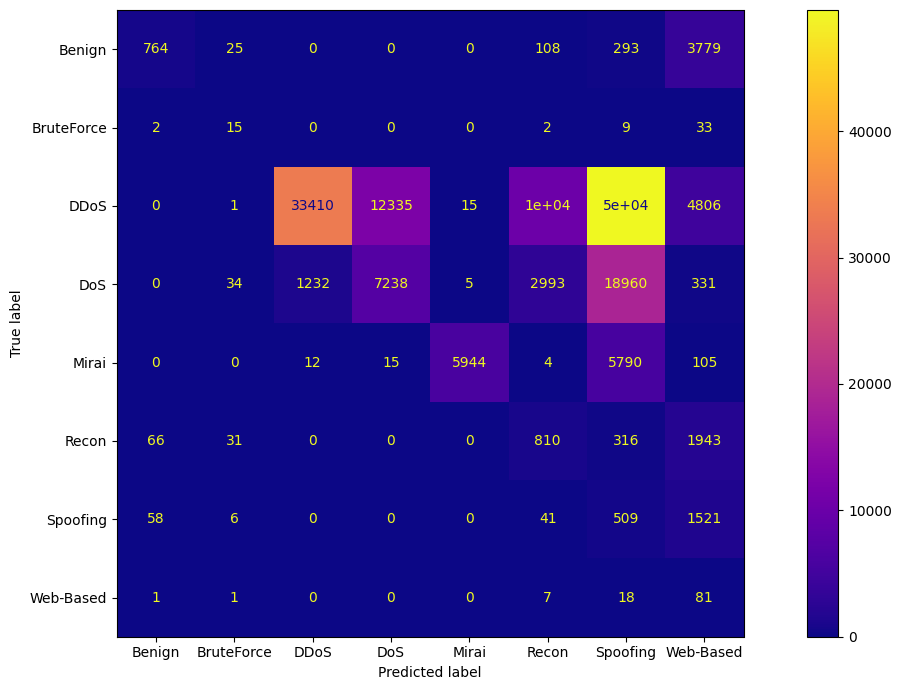


Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.15      0.26      4969
  BruteForce       0.13      0.25      0.17        61
        DDoS       0.96      0.30      0.46    110377
         DoS       0.37      0.24      0.29     30793
       Mirai       1.00      0.50      0.67     11870
       Recon       0.06      0.26      0.09      3166
    Spoofing       0.01      0.24      0.01      2135
   Web-Based       0.01      0.75      0.01       108

    accuracy                           0.30    163479
   macro avg       0.42      0.34      0.25    163479
weighted avg       0.82      0.30      0.42    163479



In [46]:
# Dictionary to store evaluation results
# --------------------------------------
multiclass_results = {
    "Model": [],
    "Accuracy": [],
    "Detection Time (s)": []
}


for model in models:
    model_name = model.__class__.__name__
    
    # Train the model
    model.fit(multiclass_X_train_resampled, multiclass_y_train_resampled) 
    
    # Measure detection time
    start_time = time.time()
    model_pred = model.predict(multiclass_X_test)               
    end_time = time.time()
    
    detection_time = round(end_time - start_time, 3)  # Time in seconds, rounded to 3 decimal places             
    
    # Compute accuracy
    accuracy = round(accuracy_score(multiclass_y_test, model_pred), 3)

    # Store results
    multiclass_results["Model"].append(model_name)
    multiclass_results["Accuracy"].append(accuracy)
    multiclass_results["Detection Time (s)"].append(detection_time)
    
    # Print results
    print(f"\nMulti-class Classification Evaluation Results for {model_name}: ")
    print("---------------------------------------------------------------------------")
    
    print(f"Accuracy: {accuracy}")
    print(f"Detection Time (s): {detection_time}")

    # Print Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(multiclass_y_test, model_pred)
    print(cm)
    
    fig, ax = plt.subplots(figsize=(13, 7))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    cm_display.plot(ax=ax, cmap='plasma')
    fig.tight_layout() 
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(multiclass_y_test, model_pred, target_names=categories))

    print("=====================================================================================")

In [47]:
# Convert results dictionary to a DataFrame
# -----------------------------------------
multiclass_results_df = pd.DataFrame(multiclass_results)
print("\nFinal Summary of Model Performance:")
print(multiclass_results_df)


Final Summary of Model Performance:
                    Model  Accuracy  Detection Time (s)
0  RandomForestClassifier     0.803               5.614
1  DecisionTreeClassifier     0.786               0.094
2    KNeighborsClassifier     0.733            1045.453
3      LogisticRegression     0.749               0.047
4               LinearSVC     0.298               0.031


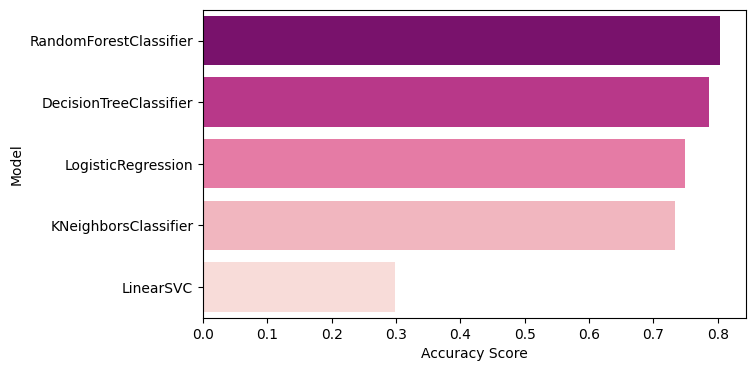

In [48]:
# Show accuracy scores
# --------------------
plt.figure(figsize=(7,4))
sns.barplot(
    data=multiclass_results_df.sort_values(by='Accuracy', ascending=False),
    x='Accuracy', 
    y='Model', 
    palette='RdPu_r'
)
plt.xlabel("Accuracy Score")
plt.show()

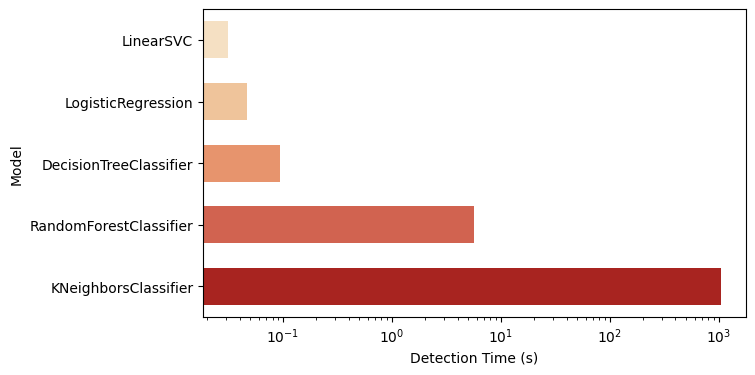

In [49]:
# Show Detection Times
# ---------------------
plt.figure(figsize=(7,4))
sns.barplot(
    data=multiclass_results_df.sort_values(by='Detection Time (s)'),
    x='Detection Time (s)', 
    y='Model', 
    width=0.6, 
    palette='OrRd'
)
plt.xscale('log')
plt.show()

In [50]:
# Show accuracy metrics for binary and multi-class models
# -------------------------------------------------------
accuracy_metrics = {
    'Model': binary_results["Model"],
    'Binary Accuracy': binary_results["Accuracy"],
    'Multi-class Accuracy': multiclass_results["Accuracy"]
}

accuracy_df = pd.DataFrame(accuracy_metrics)
accuracy_df

,Model,Binary Accuracy,Multi-class Accuracy
0,RandomForestClassifier,0.989,0.803
1,DecisionTreeClassifier,0.986,0.786
2,KNeighborsClassifier,0.976,0.733
3,LogisticRegression,0.966,0.749
4,LinearSVC,0.971,0.298


In [51]:
# Reshape the DataFrame from wide to long format
# ----------------------------------------------
accuracy_df_long = accuracy_df.melt(
    id_vars=["Model"], var_name="Accuracy Type", value_name="Accuracy Score"
)

accuracy_df_long

,Model,Accuracy Type,Accuracy Score
0,RandomForestClassifier,Binary Accuracy,0.989
1,DecisionTreeClassifier,Binary Accuracy,0.986
2,KNeighborsClassifier,Binary Accuracy,0.976
3,LogisticRegression,Binary Accuracy,0.966
4,LinearSVC,Binary Accuracy,0.971
5,RandomForestClassifier,Multi-class Accuracy,0.803
6,DecisionTreeClassifier,Multi-class Accuracy,0.786
7,KNeighborsClassifier,Multi-class Accuracy,0.733
8,LogisticRegression,Multi-class Accuracy,0.749
9,LinearSVC,Multi-class Accuracy,0.298


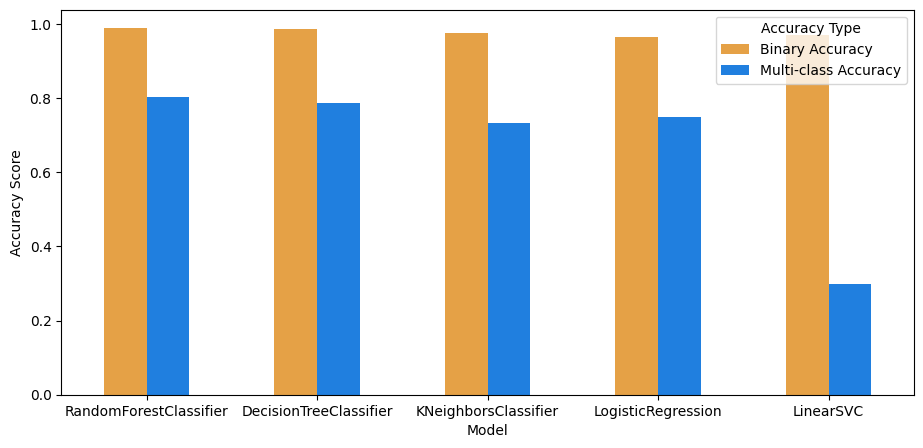

In [52]:
# Compare accuracy scores for the two tasks
# -----------------------------------------
fig, ax = plt.subplots(figsize=(11, 5))

sns.barplot(
    data=accuracy_df_long, 
    x='Model', 
    y='Accuracy Score', 
    width=0.5, 
    hue='Accuracy Type', 
    palette=['#FFA52C', '#007FFF']
)

plt.show()